In [1]:
# Allow reload of objects
%load_ext autoreload
%autoreload
from pelenet.utils import Utils
from pelenet.experiments.readout import ReadoutExperiment

# Official modules
import numpy as np
import nxsdk.api.n2a as nx
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import os
from time import time

In [2]:
# Initilizes the experiment and utils
utils = Utils.instance()
exp = ReadoutExperiment()

In [3]:
# Build network
exp.build()

# Get spectral radius
utils.getSpectralRadius(exp.net.initialWeights)

1.665

In [4]:
# Run network
exp.run()

INFO:DRV:  Connecting to 127.0.0.1:36979
INFO:DRV:      Host server up..............Done 0.06s
INFO:DRV:      Encoding axons/synapses.....Done 15.66s
Compiling in directory : /home/seq/.local/share/virtualenvs/seq-r0_WvjRo/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1586943751.7545009
Include dir is : /home/seq/05-reward/v0.x/pelenet/snips/ -I/home/seq/.local/share/virtualenvs/seq-r0_WvjRo/lib/python3.5/site-packages/nxsdk/graph/nxinputgen/../../snips/
Compiling -c /home/seq/.local/share/virtualenvs/seq-r0_WvjRo/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1586943751.7545009/initnetwork_0_0.c
gcc -Wall -I/home/seq/05-reward/v0.x/pelenet/snips/ -I/home/seq/.local/share/virtualenvs/seq-r0_WvjRo/lib/python3.5/site-packages/nxsdk/graph/nxinputgen/../../snips/ -Inxsdk/include -fno-stack-protector -msoft-float -m32 -march=i586 -fno-builtin-printf -fno-builtin-sprintf -fno-builtin-fprintf -fno-builtin-memcpy -fstrict-volatile-bitfields -Os -DNDEBUG -st

INFO:DRV:      Compiling Embedded snips....Done 0.60s
INFO:DRV:      Encoding probes.............Done 4.18ms
INFO:HST:  Using Kapoho Bay serial number 308
INFO:HST:  Args chip=0 cpu=0 /home/seq/.local/share/virtualenvs/seq-r0_WvjRo/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1586943751.7545009/launcher_chip0_lmt0.bin --chips=2 --remote-relay=0 --epoch=0 
INFO:HST:  Args chip=1 cpu=0 /home/seq/.local/share/virtualenvs/seq-r0_WvjRo/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1586943751.7545009/launcher_chip1_lmt0.bin --chips=2 --remote-relay=0 --epoch=0 
INFO:HST:  Lakemont_driver...
INFO:DRV:      Booting up..................Done 1.28s
INFO:DRV:      Transferring probes.........Done 0.04s
INFO:DRV:      Configuring registers.......Done 14.86s
INFO:DRV:      Transferring spikes.........Done 0.03s
INFO:HST:  chip=1 cpu=0 Transfered values 20, 235, 30 
INFO:HST:  chip=0 cpu=0 Transfered values 20, 235, 30 
INFO:HST:  chip=1 cpu=0 Reset current/volt

INFO:HST:  chip=1 cpu=0 Reset current/voltage from time step 3760 to 3790
INFO:HST:  chip=0 cpu=0 Reset functional state at 3790
INFO:HST:  chip=1 cpu=0 Reset functional state at 3790
INFO:HST:  chip=1 cpu=0 Reset current/voltage from time step 3995 to 4025
INFO:HST:  chip=0 cpu=0 Reset current/voltage from time step 3995 to 4025
INFO:HST:  chip=1 cpu=0 Reset functional state at 4025
INFO:HST:  chip=0 cpu=0 Reset functional state at 4025
INFO:HST:  chip=1 cpu=0 Reset current/voltage from time step 4230 to 4260
INFO:HST:  chip=0 cpu=0 Reset current/voltage from time step 4230 to 4260
INFO:HST:  chip=1 cpu=0 Reset functional state at 4260
INFO:HST:  chip=0 cpu=0 Reset functional state at 4260
INFO:HST:  chip=1 cpu=0 Reset current/voltage from time step 4465 to 4495
INFO:HST:  chip=0 cpu=0 Reset current/voltage from time step 4465 to 4495
INFO:HST:  chip=1 cpu=0 Reset functional state at 4495
INFO:HST:  chip=0 cpu=0 Reset functional state at 4495
INFO:HST:  chip=1 cpu=0 Reset current/volt

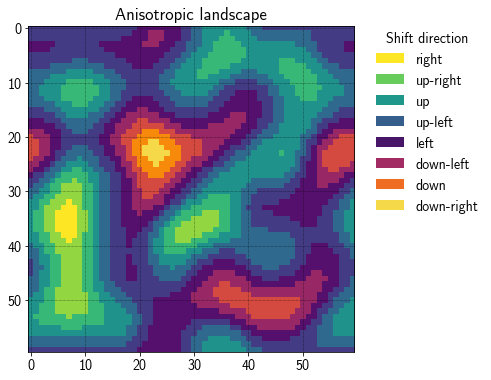

In [5]:
exp.net.plot.landscape()

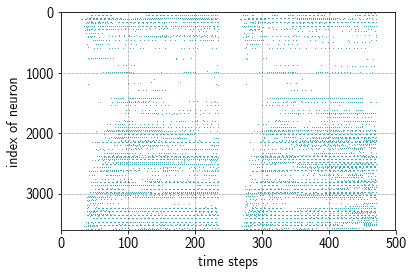

In [6]:
exp.net.plot.reservoirSpikeTrain(fr=0, to=500)
#exp.net.plot.reservoirSpikeTrain()

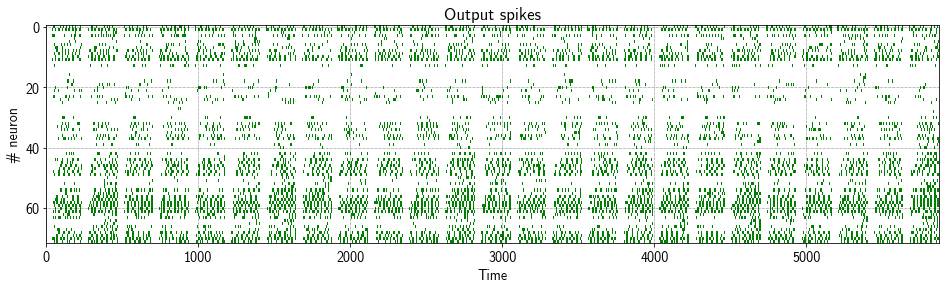

In [7]:
exp.net.plot.outputSpikeTrain()

In [8]:
# Prepare data for statistics

offset = exp.p.resetOffset + exp.p.inputOffset
data = []
for i in range(exp.p.trials):
    fr, to = (i+1)*offset+i*exp.p.stepsPerTrial, (i+1)*offset+(i+1)*exp.p.stepsPerTrial
    #data.append(exp.net.outSpikeTrains[:,fr:to])
    data.append(exp.net.exSpikeTrains[:,fr:to])
data = np.array(data)

# Store data
#import os
#dirPath = os.getcwd()
#np.save(dirPath+'/data-out_2020-04-14_anisotropic.npy', data)
#np.save(dirPath+'/data-ex_2020-04-14_anisotropic.npy', data)

data.shape

(25, 3600, 200)

# Differences between two trials

diff01 = np.abs(data[0] - data[2])
p = plt.plot(np.sum(diff01, axis=0))
plt.ylim(0,700)

#plt.figure(figsize=(16, 16))
#p = plt.imshow(diff01)

# Diffs

binSize = 20
bins = np.array([np.mean(data[:, :, i:i+binSize], axis=2) for i in range(0,data.shape[2],binSize)])
bins.shape  # time, trials, neurons

difs = []
for i in range(1,16):
    dif = np.abs(bins[:,i,:] - bins[:,i+1,:])
    difs.append(dif)
difs = np.array(difs)
    
dif_mean = np.sum(difs, axis=(0,2))/3600
dif_sd = np.std(difs, axis=(0,2))

#p = plt.errorbar(dif_mean, yerr=dif_sd)

# PCA

binSize = 10

dtrans = []
for i in range(data.shape[0]):
    dataBinned = np.array([np.mean(data[i, :, j:j+binSize], axis=1) for j in range(0,data[i].shape[1],binSize)])
    (d, evals, evecs) = utils.pca(dataBinned.astype(float), dims_rescaled_data=1)
    dtrans.append(d)

#for i in range(data.shape[0]):

for i in range(25):
    plt.plot(dtrans[i])